# comparaison beetween ship/hipp and friedrichknuth/hipp

This notebook used to illustrate the difference beetween shipp/hipp and friedrichknuth/hipp
Note: shipp/hipp is almost a copy of friedrichknuth/hipp with some small differences

To illustrate the difference let's use the same dataset shown in the [image restitution notebook](https://github.com/friedrichknuth/hipp/blob/master/examples/image_restitution/notebook.ipynb). This dataset is composed of 41 images of the South Cascade Glacier in 09/06/1994

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import hipp
import os

The first difference is the usage of a class. The `hipp.AerialPreprocessing` class is used here to simplify the path management to manage quality control and to allow multi-thread. But all of the logic are in hipp/aerial/core.py.

So let create an instance of this class with all path we want:
- `images_directory`: The directory who contain our 41 tif images
- `fiducials_directory`: The directory of fiducials templates we will create (or existing)
- `preprocess_images`: The output directory to put preprocessed images
- `qc_directory`: The directory to store all quality control stuffs

In [18]:
images_directory = "/home/godinlu/Documents/history-dataset/1994_06_09_aerial_scg/raw_images"

preproc = hipp.AerialPreprocessing(images_directory)

## Creation of fiducials templates

Fiducial templates are created using a single method, `create_fiducial_template`, which can be called with either "corner" or "midside" to generate the corresponding template. This method allows you to click on the full-resolution image to select the fiducial. It then enhances the image resolution and lets you click precisely on the center of the fiducial to achieve subpixel accuracy.

The equivalent functions in `friedrichknuth/hipp` are:
```python
hipp.core.create_fiducial_template
hipp.utils.enhance_geotif_resolution
hipp.core.create_fiducial_template
```
Another key difference is in the point selection interface: this version uses OpenCV (cv2) instead of Panel. While the OpenCV-based approach is less powerful—since it loads the full image rather than streaming image tiles based on zoom level—it is lighter and faster for standard-size images. Panel, although more advanced, is significantly heavier in terms of dependencies and runtime performance.

In [22]:
preproc.create_fiducial_template(corner=True)

In [24]:
preproc.create_fiducial_template(midside=True)

## Detection of fiducials on images

The first difference is the way of use subblock of the image. The image is divided in n*n blocks where n is the parameters `grid_size` of the detect_fiducials method (`grid_size` must be an odd number). It's important that the corner image block fit the corner fiducial and the midside block fit the midside fiducial. It improve the speed of the detection and the ram consuption because we don't load the full image.

This method use of multi-thread to increase the speed of the detection.

In terms of time it detect all fiducials of the 41 images (midside and corners) in 20 seconds for 4min30 for `friedrichknuth/hipp`.

The computation of the principal point is slightly different cause we compute pp with all fiducials even if some fiducials are miss detected.
So some principal points are false and we can see this in the principal points deviation plot.




Fiducials detection:   0%|          | 0/41 [00:00<?, ?it/s]

Fiducials detection: 100%|██████████| 41/41 [00:15<00:00,  2.58it/s]


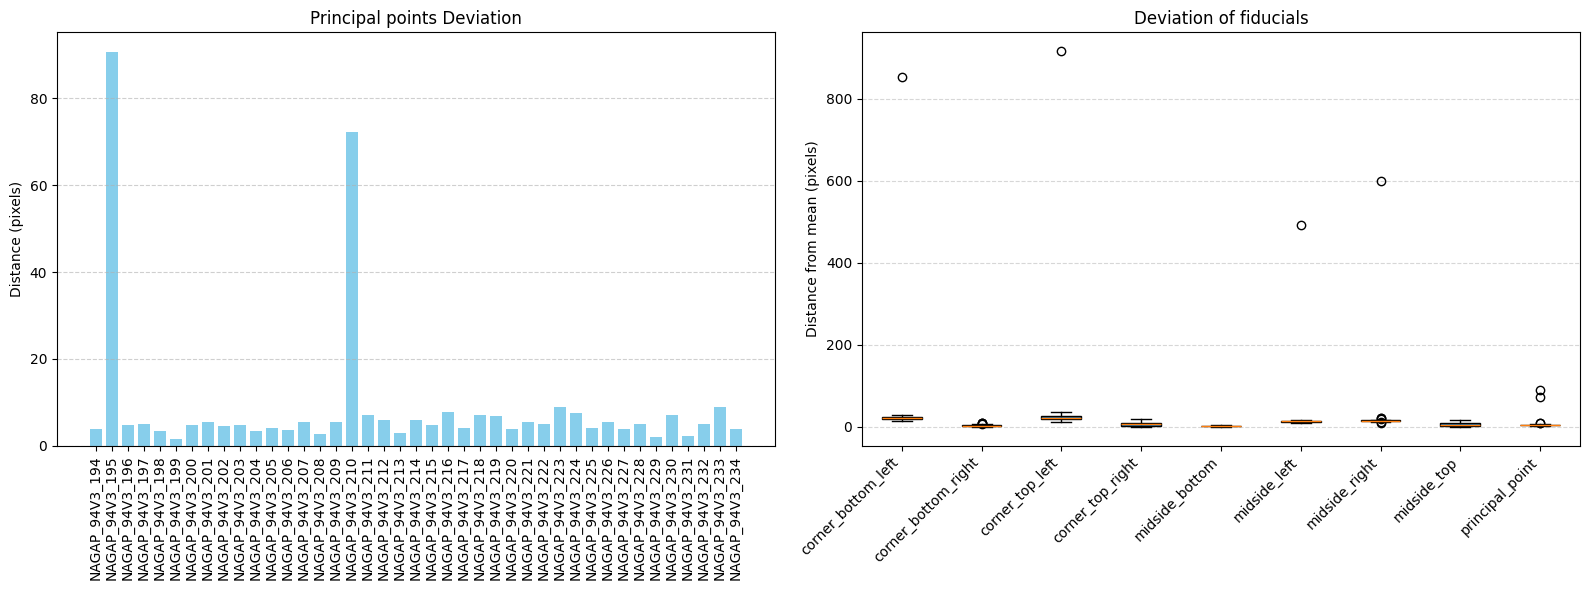

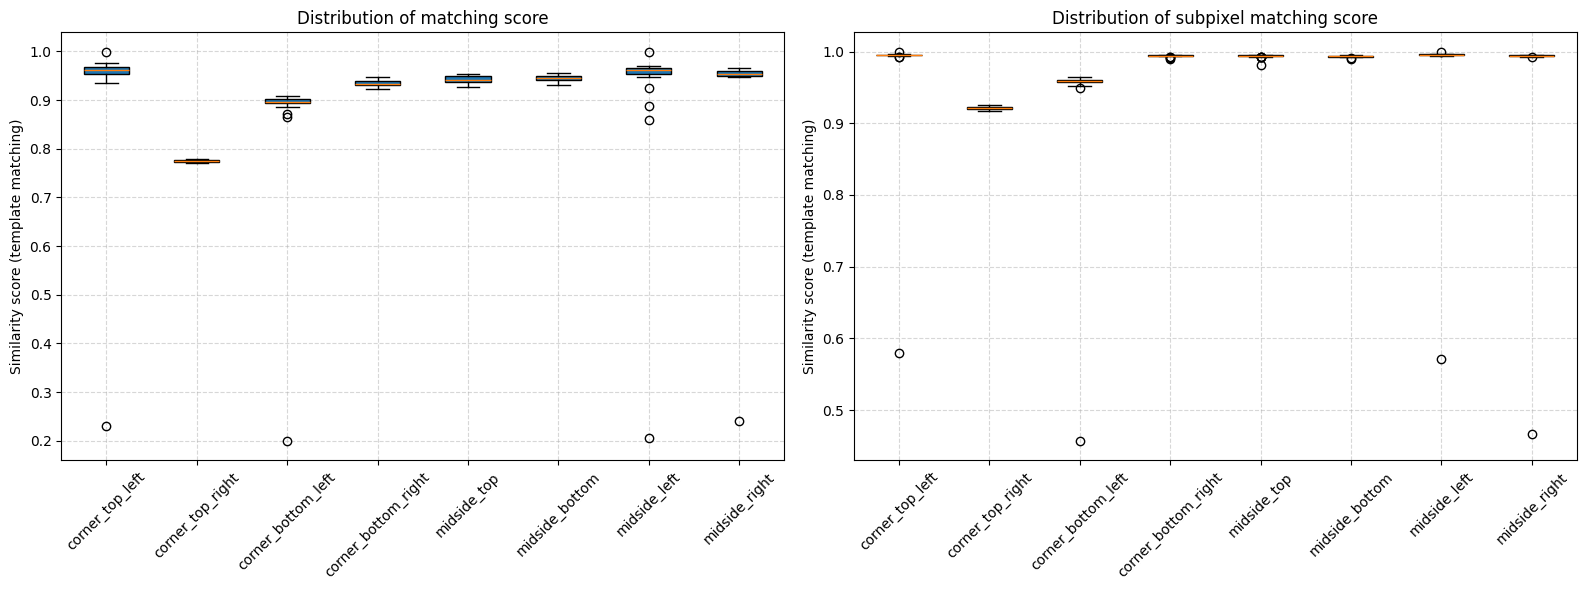

In [25]:
all_detections, all_scores, all_subpixel_scores = preproc.detect_fiducials(grid_size=7, max_workers=5)

## Remove wrong detection

same as `friedrichknuth/hipp` we set None all miss fiducial detections with the `process_fiducials_detection` method. We validate a detection with 2 methods a geometric one and a score based method. The detection is valid if at least one validation is passed. The most important validation is the score based method. We calculate for each group of fiducials ("corner_top_right", ...) the median. Then we validate each detection with a score above the median with a treshold (0.1). The second validation is to compare each angle with 90 degree, if an angle is closed enough of 90 degree we validate the 3 points. This second step can be usefull to validate detection that have a low matching score but are still true. 

After removing all miss detections we compute an other time the principal point on valid detection. So we can observe some upgrade in the Principal points deviation.

**Note** : the computing of the principal point of `shipp/hipp` include also valid edge instead of taking only diagonal. 

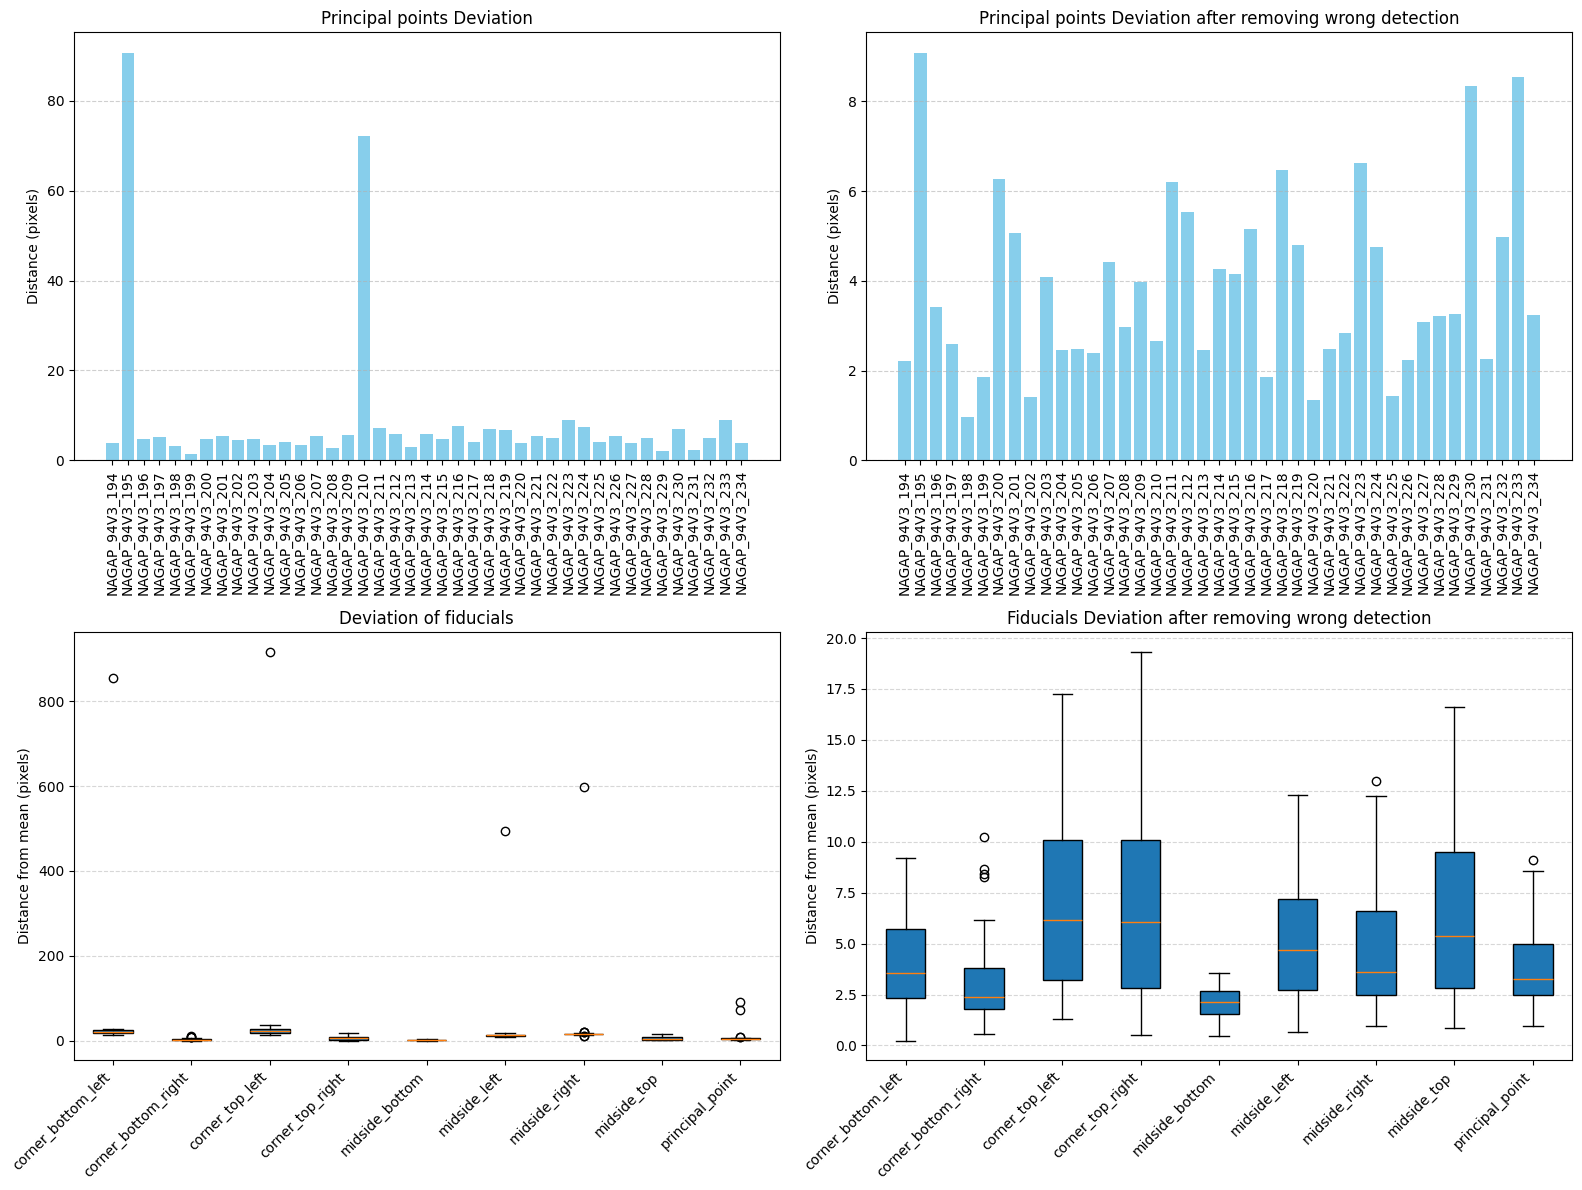

In [29]:
processed_detections = preproc.process_fiducials_detection(all_detections, all_scores, all_subpixel_scores, degree_threshold=0.005)

## Image restitution

The goal of this step is to correct some small distortion in the image. To achieve this, the objective is to align the detected fiducials with true fiducials founded in calibration report. 
1. **Align true fiducials** : Align the `true_fiducials_mm` with is principal point, cause it's not (0, 0).
2. **Convert pixels to mm** : Convert the coordinate of fiducials detection in the same referencial of the calibration report so in mm. To do this we take the principal point for the origin (0,0) and we multiply with the `scanning_resolution_mm`. (also need to invert y axis)
3. **Estimate the transformation** : Estimate the transformation beetween detections and true fiducials. Here we use similarity transformation so angles will not be modified.

In [30]:
true_fiducials_mm = {
    "corner_bottom_left": (-109.990, -110.002), # 1
    "corner_top_right": (110.010, 109.999), # 2
    "corner_top_left": (-109.989, 109.9995), # 3
    "corner_bottom_right": (109.998, -110.002), # 4
    "midside_left": (-111.998, -0.004), # 5
    "midside_right": (112.004, 0.000), # 6
    "midside_top": (-0.014, 111.993), # 7
    "midside_bottom": (0.000, -112.002) # 8
}

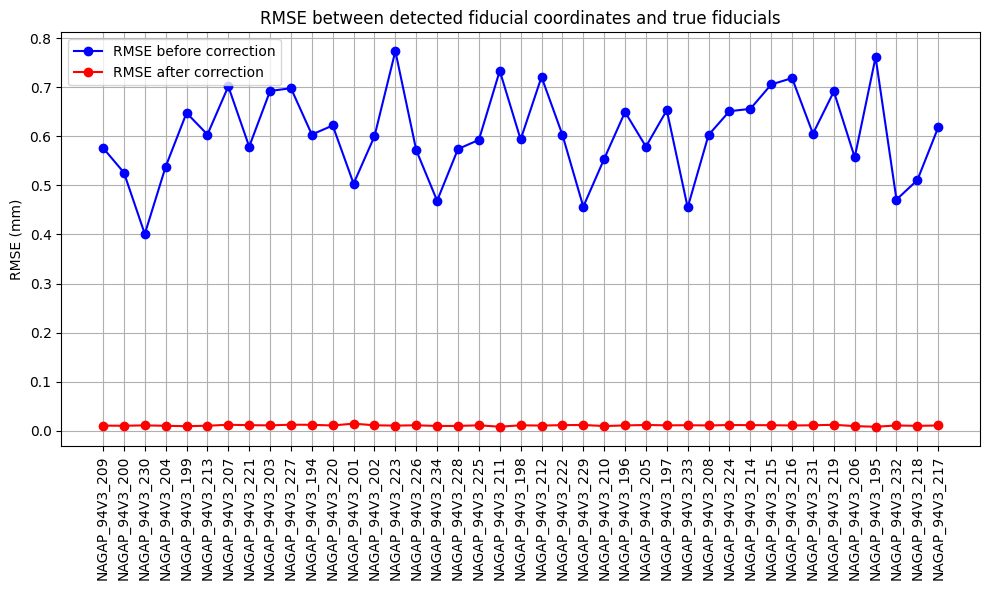

In [31]:
res = preproc.images_restitution(
    processed_detections,
    true_fiducials_mm,
    image_square_dim=10800,
    scanning_resolution_mm=0.02,
    transform_image=False,
    crop_image=False,
    clahe_enhancement=False
)

As we can see, applying the correction should reduce the RMSE between the detected fiducials and the true fiducials. However, it’s important to note that the RMSE after correction is computed solely based on coordinates. To ensure that the correction is truly effective, we will apply it to all images without cropping, and then perform a new fiducial detection. This second detection will help verify whether the observed improvement is genuine and consistent across the dataset.

In [32]:
# apply transformation to all image without cropping
_ = preproc.images_restitution(
    processed_detections,
    true_fiducials_mm,
    image_square_dim=10800,
    scanning_resolution_mm=0.02,
    transform_image=True,
    crop_image=False,
    clahe_enhancement=False,
    quality_control=False
)

Image restitution: 100%|██████████| 41/41 [00:33<00:00,  1.24img/s]


Here, we create a new `AerialPreprocessing` instance using the transformed images as the input directory. We then run fiducial detection and process the results. Finally, we generate an image restitution plot to visualize the RMSE of the new fiducial detections.

Fiducials detection:   0%|          | 0/41 [00:00<?, ?it/s]

Fiducials detection: 100%|██████████| 41/41 [00:14<00:00,  2.74it/s]


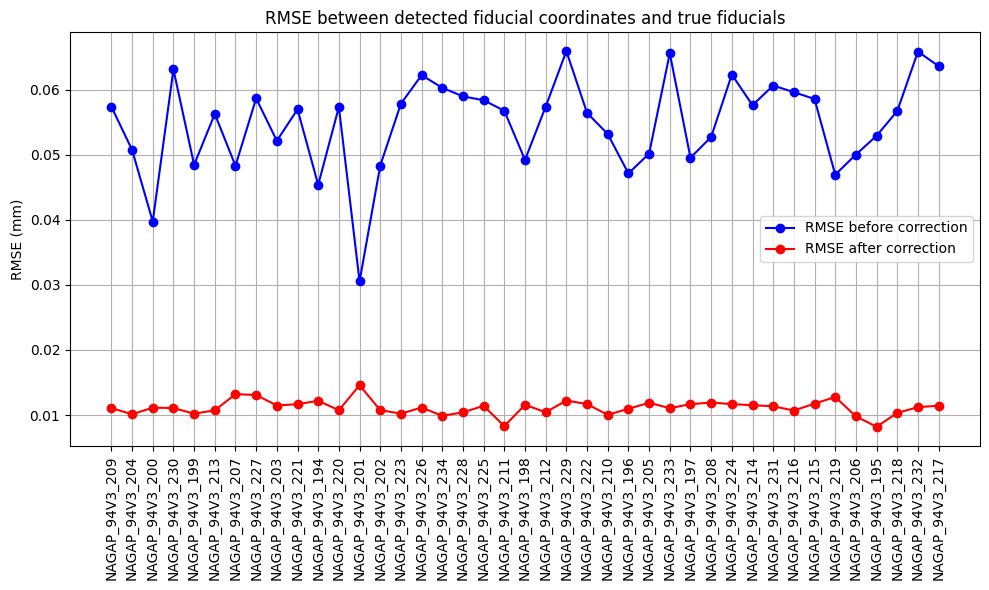

In [34]:
project_directory = "/home/godinlu/Documents/history-dataset/1994_06_09_aerial_scg"
images_directory = os.path.join(project_directory, "output_images")
fiducial_directory = os.path.join(project_directory, "fiducials")
output_directory = os.path.join(project_directory, "final_images")
qc_directory = os.path.join(project_directory, "qc2")

preproc2 = hipp.AerialPreprocessing(
    images_directory=images_directory,
    fiducials_directory=fiducial_directory,
    output_directory=output_directory,
    qc_directory=qc_directory
)

detection_result2 = preproc2.detect_fiducials(grid_size=7, max_workers=5, quality_control=False)
processed_detections2 = preproc2.process_fiducials_detection(*detection_result2, quality_control=False)
_ = preproc.images_restitution(
    processed_detections2,
    true_fiducials_mm,
    image_square_dim=10800,
    scanning_resolution_mm=0.02,
    transform_image=False,
    crop_image=False,
    clahe_enhancement=False
)


As we observe, the RMSE significantly improves — decreasing from approximately 0.6 mm to 0.06 mm. However, the results are not as perfect as initially expected. This is quite logical, as the precision is fundamentally limited by the pixel resolution.